# Multi-linear regression: how many variables?
#### by Elizabeth Barnes
If I have two predictors $x_1$ and $x_2$, under what circumstances is the second one useful for predicting $y$?

In [113]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

#.............................................
# IMPORT STATEMENTS
#.............................................
import numpy as np
import matplotlib.pyplot as plt
import importlib
from sklearn import linear_model
from sklearn import metrics


Let's start by creating two predictors, x1 and x2, and predictand y. x1 will be totally random, and the others will build upon that.

In [114]:
x1 = np.random.normal(0.,1.,size=100,)
print(np.shape(x1))

(100,)


Now we create x2.

In [115]:
a = 0.8
b = np.sqrt(1. - a**2)
x2 = []

# create red-noise time series iteratively
for it in np.arange(0,100,1):
    x2.append(a*x1[it] + b*np.random.normal(size=1))

x2 = np.asarray(x2)[:,0]    
print(np.shape(x2))

(100,)


In [116]:
np.corrcoef(x1,x2)[0,1]

0.7620959476531619

Now let's make $y$, which is composed of pieces of x1, x2 and noise.

In [117]:
a = 0.3
b = np.sqrt(1. - a**2)
y = []

# create red-noise time series iteratively
for it in np.arange(0,100,1):
    y.append(a*x1[it] + (.05)*x2[it] + b*np.random.normal(size=1))

y = np.asarray(y)[:,0]    
print(np.shape(y))

(100,)


We can calculate the correlations of the predictors and predictands just to confirm that they all have some relationship with one another.

In [118]:
c12 = np.corrcoef(x1,x2)[0,1]
c1y = np.corrcoef(x1,y)[0,1]
c2y = np.corrcoef(y,x2)[0,1]

print(c12)
print(c1y)
print(c2y)

0.7620959476531619
0.41894282434218905
0.4731432204342064


### Theory

Based on theory, the minimum useful correlation of c2y is the following (from theory)...

In [119]:
minUseful = np.abs(c1y*c12)
print(minUseful)

0.3192746287295527


Furthermore, we can show analytically that the variance explained between using x1 versus x1 and x2 is practically identical since x2 doesn't appear to add additional information (i.e. |c2y| < minUseful).

In [121]:
#just using x1
R2 = c1y**2
print(R2)

#using x1 and x2
R2 = (c1y**2 + c2y**2 - 2*c1y*c2y*c12)/(1-c12**2)
print(R2)

0.17551309006781027
0.2319896929553161


### Actual fits

We can confirm the theory now through some fun examples where we actually fit y using x1 and x2. In fact, we see that the fits indeed give us exactly what is expected by theory.

In [122]:
# only x1 predictor
X = np.swapaxes([x1],1,0)
Y = np.swapaxes([y],1,0)

# with sklearn
regr = linear_model.LinearRegression()
regr.fit(X, Y)
R2_x1 = metrics.r2_score(Y,regr.predict(X))
print(R2_x1)

#---------------------------------------------
# both x1 and x2 predictors
X = np.swapaxes([x1,x2],1,0)
Y = np.swapaxes([y],1,0)

# with sklearn
regr = linear_model.LinearRegression()
regr.fit(X, Y)
R2_x12 = metrics.r2_score(Y,regr.predict(X))
print(R2_x12)

0.17551309006781035
0.2319896929553158


But what is going on here? Why is the $R^2$ slightly higher when we added x2? I thought theory said it shouldn't improve my variance explained?

## What about more predictors? (aka _overfitting_)

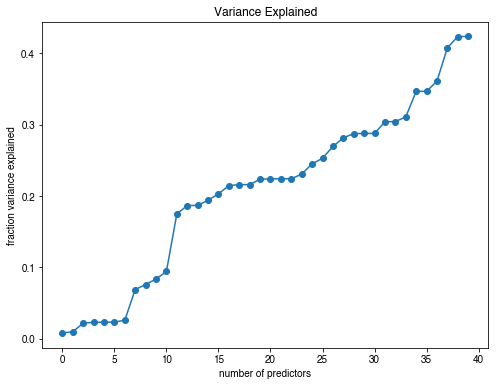

In [123]:
X = np.random.normal(0.,1.,size=(100,40))
Y = np.random.normal(0.,1.,size=100,)

rval = []
for n in np.arange(0,np.shape(X)[1]):
    # with sklearn
    regr = linear_model.LinearRegression()
    regr.fit(X[:,0:n+1], Y)
    R2 = metrics.r2_score(Y,regr.predict(X[:,0:n+1]))
    rval.append(R2)
    
plt.figure(figsize=(8,6))
plt.plot(np.arange(0,np.shape(X)[1]),rval,'o-')
plt.xlabel('number of predictors')
plt.ylabel('fraction variance explained')
plt.title('Variance Explained')
plt.show()

### Adjusted R2

There is a great solution to this - known as the _adjusted $R^2$_. It is a measure of explained variance, but you are penalized (the number decreases) whe too many predictors are used. The adjusted $R^2$ increases only if the new term improves the model more than would be expected by chance.

In [125]:
def adjustRsquared(r2,n,p):
    adjustR2 = 1 - (1-r2)*(n-1)/(n-p-1)
    return adjustR2

In [126]:
# only fitting with x1
p=1
n = len(x1)
adjustR2 = adjustRsquared(R2_x1,n,p)
print(R2_x1,adjustR2)

# fitting with x1 and x2
p = 2
n = len(x1)
adjustR2 = adjustRsquared(R2_x12,n,p)
print(R2_x12,adjustR2)

0.17551309006781035 0.16709995833380842
0.2319896929553158 0.21615442889253877


In our silly example above with 40 predictors, the adjusted R2 is the following...

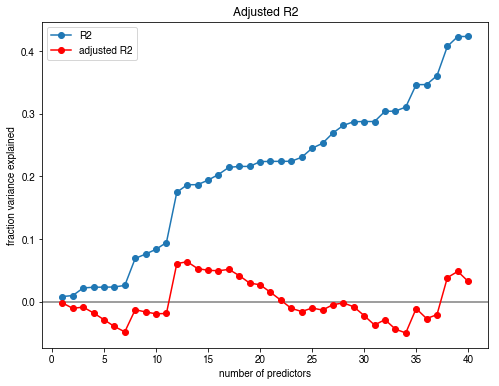

In [127]:
n = len(Y)
p = np.arange(0,np.shape(X)[1]) + 1
adjustR2 = adjustRsquared(np.asarray(rval),n,p)

plt.figure(figsize=(8,6))
plt.axhline(y=0,color='gray')
plt.plot(np.arange(1,np.shape(X)[1]+1),rval,'o-', label='R2')
plt.plot(np.arange(1,np.shape(X)[1]+1),adjustR2,'o-',color='red', label='adjusted R2')
plt.xlabel('number of predictors')
plt.ylabel('fraction variance explained')
plt.legend()
plt.title('Adjusted R2')
plt.show()

### Significance of Adjusted $R^2$

In [128]:

rVec = np.zeros(shape=(40,500))
for nvar in np.arange(1,41):
    r = []
    for n in np.arange(0,500):
        X = np.random.normal(0.,1.,size=(100,nvar))
        Y = np.random.normal(0.,1.,size=100,)

        # with sklearn
        regr = linear_model.LinearRegression()
        regr.fit(X[:,0:n+1], Y)
        R2 = metrics.r2_score(Y,regr.predict(X[:,0:n+1]))
        r.append(R2)

    rVec[nvar-1,:] = adjustRsquared(np.asarray(r),100,nvar)

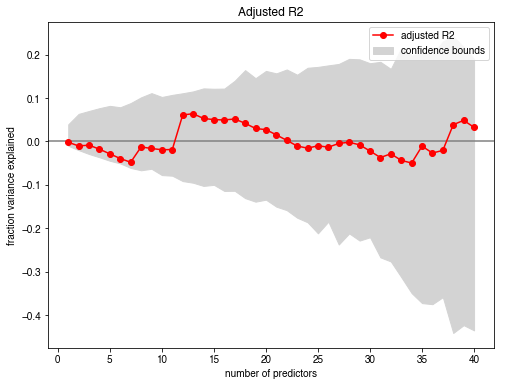

In [129]:
pTop = np.percentile(rVec,97.5,axis=1)
pBot = np.percentile(rVec,2.5,axis=1)

plt.figure(figsize=(8,6))
plt.axhline(y=0,color='gray')
plt.plot(np.arange(1,np.shape(X)[1]+1),adjustR2,'o-',color='red', label='adjusted R2')
plt.fill_between(np.arange(1,len(p)+1), pBot, pTop,color='lightgray', label='confidence bounds')

plt.xlabel('number of predictors')
plt.ylabel('fraction variance explained')
plt.legend()
plt.title('Adjusted R2')
plt.show()